In [1]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

data = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

In [2]:
data

No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd     Iws  \
0          1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW    1.79   
1          2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW    4.92   
2          3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW    6.71   
3          4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW    9.84   
4          5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW   12.97   
...      ...   ...    ...  ...   ...    ...   ...   ...     ...  ...     ...   
43819  43820  2014     12   31    19    8.0   -23  -2.0  1034.0   NW  231.97   
43820  43821  2014     12   31    20   10.0   -22  -3.0  1034.0   NW  237.78   
43821  43822  2014     12   31    21   10.0   -22  -3.0  1034.0   NW  242.70   
43822  43823  2014     12   31    22    8.0   -22  -4.0  1034.0   NW  246.72   
43823  43824  2014     12   31    23   12.0   -21  -3.0  1034.0   NW  249.85   

       Is  Ir  
0       0   0  
1       0   0  
2       0   0  
3       0   0  
4       0   0  
...    ..  ..  
43819   0   0  
43820   0   0  
43821   0   0  
43822   0   0  
43823   0   0  

[43824 rows x 13 columns]

In [3]:
cbwd = pd.get_dummies(data['cbwd'])
cbwd.columns = ["cbwd_{}".format(i) for i in range(cbwd.shape[1])]
data = pd.concat([data, cbwd], axis=1)

In [4]:
data.drop(['cbwd'], axis=1, inplace=True)


In [5]:
data['pm2.5'] = data['pm2.5'].fillna(method='ffill').fillna(method='bfill')

In [6]:
data

No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES     Iws  Is  \
0          1  2010      1    1     0  129.0   -21 -11.0  1021.0    1.79   0   
1          2  2010      1    1     1  129.0   -21 -12.0  1020.0    4.92   0   
2          3  2010      1    1     2  129.0   -21 -11.0  1019.0    6.71   0   
3          4  2010      1    1     3  129.0   -21 -14.0  1019.0    9.84   0   
4          5  2010      1    1     4  129.0   -20 -12.0  1018.0   12.97   0   
...      ...   ...    ...  ...   ...    ...   ...   ...     ...     ...  ..   
43819  43820  2014     12   31    19    8.0   -23  -2.0  1034.0  231.97   0   
43820  43821  2014     12   31    20   10.0   -22  -3.0  1034.0  237.78   0   
43821  43822  2014     12   31    21   10.0   -22  -3.0  1034.0  242.70   0   
43822  43823  2014     12   31    22    8.0   -22  -4.0  1034.0  246.72   0   
43823  43824  2014     12   31    23   12.0   -21  -3.0  1034.0  249.85   0   

       Ir  cbwd_0  cbwd_1  cbwd_2  cbwd_3  
0       0       0       1       0       0  
1       0       0       1       0       0  
2       0       0       1       0       0  
3       0       0       1       0       0  
4       0       0       1       0       0  
...    ..     ...     ...     ...     ...  
43819   0       0       1       0       0  
43820   0       0       1       0       0  
43821   0       0       1       0       0  
43822   0       0       1       0       0  
43823   0       0       1       0       0  

[43824 rows x 16 columns]

In [7]:
from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[5:]].values.reshape(-1,11)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [8]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test,test1 = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:],scaled[train_size:,]
print(len(train),len(val), len(test))

35059 4382 4383


In [9]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [10]:
look_back = 24
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)
test1X, test1Y = create_dataset_mul(test1, look_back)

35035
4358
4359
8741


In [11]:
print(trainX.shape)
print(trainY.shape)

(35035, 24, 11)
(35035,)


(<Figure size 1152x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa68be59f98>)

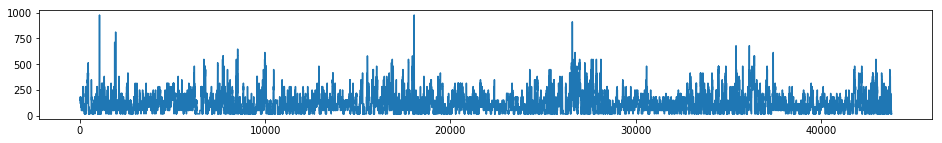

In [13]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
from tsaug.visualization import plot

my_augmenter = (Quantize(n_levels=[30]))
X_aug1= my_augmenter.augment(data['pm2.5'].values)
plot(X_aug1)

In [14]:
quant=scaler.fit_transform(X_aug1.reshape(-1,1))

In [15]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train_q,val_q, test_q = quant[0:train_size,:],quant[train_size:train_size+val_size,:], quant[train_size+val_size:,:]
print(len(train_q),len(val_q), len(test_q))

35059 4382 4383


In [16]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [17]:
look_back = 24
trainX_q, trainY_q = create_dataset(train_q, look_back)
valX_q, valY_q = create_dataset(val_q, look_back)
testX_q, testY_q = create_dataset(test_q, look_back)

35035
4358
4359


In [18]:
look_back = 24
trainX_o, trainY_o = create_dataset(train, look_back)
valX_o, valY_o = create_dataset(val, look_back)
testX_o, testY_o = create_dataset(test, look_back)

35035
4358
4359


In [19]:
trainX_q = np.reshape(trainX_q, (trainX_q.shape[0], trainX_q.shape[1], 1))
valX_q = np.reshape(valX_q, (valX_q.shape[0], valX_q.shape[1],1))
testX_q = np.reshape(testX_q, (testX.shape[0],testX_q.shape[1], 1 ))

In [20]:
trainX_o = np.reshape(trainX_o, (trainX_o.shape[0], trainX_o.shape[1], 1))
valX_o = np.reshape(valX_o, (valX_o.shape[0], valX_o.shape[1],1))
testX_o = np.reshape(testX_o, (testX_o.shape[0],testX_o.shape[1], 1 ))

In [21]:
print(trainX.shape)
print(trainX_q.shape)

(35035, 24, 11)
(35035, 24, 1)


In [22]:
print(valX.shape)
print(valX_q.shape)

(4358, 24, 11)
(4358, 24, 1)


In [73]:
first_input = Input(shape=(24,1))
in1=layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(6, 1))(first_input)
in2=layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(6, 1))(in1)
#in3=layers.Conv1D(filters=128, kernel_size=1, activation='relu')(in2)
in4=layers.MaxPooling1D(pool_size=2)(in2)
in5=layers.Flatten()(in4)
in6=layers.Dense(100)(in5)
#in6=layers.Dense(1)(in6)
#in6=layers.Bidirectional(LSTM(50))(first_input)

inputs = Input(shape=(24, 11), name='inputs')
#lstm_out = Bidirectional(LSTM(80, return_sequences=False))(inputs)
lstm_out = LSTM(50, return_sequences=False)(inputs)

#lstm_out = LSTM(64, return_sequences=True)(lstm_out)

    # Attention layer
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([lstm_out, lstm_out])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([lstm_out, attn_out])
#flat_out = Flatten()(concat_out)

    # Dense layer
#dense_out = Dense(6, activation='relu')(flat_out)
concat=layers.Concatenate()([in6, lstm_out])
#dens=layers.Dense(100,activation='relu')(concat)
#dens=layers.Dense(100)
#dens= SeqSelfAttention(attention_activation='relu')(concat)

dens=layers.Dense(1)(concat)

model=tf.keras.Model(inputs=[first_input,inputs],outputs=[dens])
model.compile(optimizer='adam', loss='mse')


In [74]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 20, 64)       384         input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 20, 64)       4160        conv1d_14[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 10, 64)       0           conv1d_15[0][0]                  
____________________________________________________________________________________________

In [75]:
checkpoint_path = "saved_weights/multi_pm2.5_onestep_50.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [76]:
hist = model.fit([trainX_o,trainX],trainY, epochs = 100,validation_data=([valX_o,valX],valY), verbose = 1,callbacks=[cb])

Train on 35035 samples, validate on 4358 samples
Epoch 1/100
34912/35035 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00001: val_loss improved from inf to 0.00073, saving model to saved_weights/multi_pm2.5_onestep_50.hdf5
35035/35035 [==============================] - 10s 283us/sample - loss: 0.0011 - val_loss: 7.3073e-04
Epoch 2/100
34880/35035 [============================>.] - ETA: 0s - loss: 7.0898e-04
Epoch 00002: val_loss improved from 0.00073 to 0.00062, saving model to saved_weights/multi_pm2.5_onestep_50.hdf5
35035/35035 [==============================] - 8s 227us/sample - loss: 7.0762e-04 - val_loss: 6.1780e-04
Epoch 3/100
34944/35035 [============================>.] - ETA: 0s - loss: 6.5901e-04
Epoch 00003: val_loss did not improve from 0.00062
35035/35035 [==============================] - 8s 226us/sample - loss: 6.5860e-04 - val_loss: 6.8242e-04
Epoch 4/100
34944/35035 [============================>.] - ETA: 0s - loss: 6.2760e-04
Epoch 00004: val_loss im

34912/35035 [============================>.] - ETA: 0s - loss: 4.9777e-04
Epoch 00032: val_loss did not improve from 0.00054
35035/35035 [==============================] - 8s 226us/sample - loss: 4.9690e-04 - val_loss: 5.5615e-04
Epoch 33/100
34912/35035 [============================>.] - ETA: 0s - loss: 4.9744e-04
Epoch 00033: val_loss did not improve from 0.00054
35035/35035 [==============================] - 8s 225us/sample - loss: 4.9753e-04 - val_loss: 5.8389e-04
Epoch 34/100
34976/35035 [============================>.] - ETA: 0s - loss: 4.9364e-04
Epoch 00034: val_loss did not improve from 0.00054
35035/35035 [==============================] - 8s 227us/sample - loss: 4.9402e-04 - val_loss: 5.5974e-04
Epoch 35/100
34912/35035 [============================>.] - ETA: 0s - loss: 4.9277e-04
Epoch 00035: val_loss did not improve from 0.00054
35035/35035 [==============================] - 8s 226us/sample - loss: 4.9211e-04 - val_loss: 5.8748e-04
Epoch 36/100
34880/35035 [===============

Epoch 66/100
34784/35035 [============================>.] - ETA: 0s - loss: 4.2675e-04
Epoch 00066: val_loss did not improve from 0.00054
35035/35035 [==============================] - 8s 225us/sample - loss: 4.2637e-04 - val_loss: 5.5534e-04
Epoch 67/100
35008/35035 [============================>.] - ETA: 0s - loss: 4.2961e-04
Epoch 00067: val_loss did not improve from 0.00054
35035/35035 [==============================] - 8s 226us/sample - loss: 4.2965e-04 - val_loss: 5.7598e-04
Epoch 68/100
34912/35035 [============================>.] - ETA: 0s - loss: 4.2624e-04
Epoch 00068: val_loss did not improve from 0.00054
35035/35035 [==============================] - 8s 226us/sample - loss: 4.2537e-04 - val_loss: 5.8306e-04
Epoch 69/100
34944/35035 [============================>.] - ETA: 0s - loss: 4.2643e-04
Epoch 00069: val_loss did not improve from 0.00054
35035/35035 [==============================] - 8s 226us/sample - loss: 4.2651e-04 - val_loss: 5.7664e-04
Epoch 70/100
34848/35035 [==

Epoch 100/100
35008/35035 [============================>.] - ETA: 0s - loss: 3.7401e-04
Epoch 00100: val_loss did not improve from 0.00054
35035/35035 [==============================] - 8s 226us/sample - loss: 3.7385e-04 - val_loss: 6.3541e-04


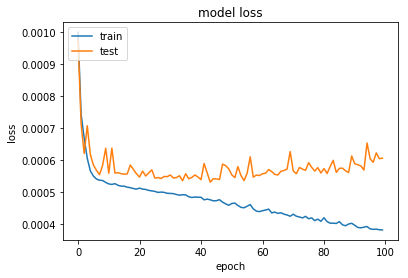

In [70]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

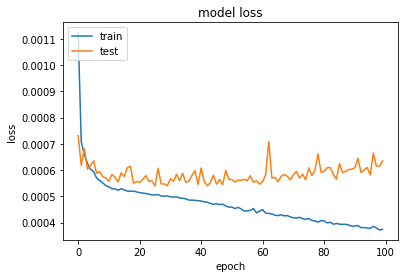

In [77]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

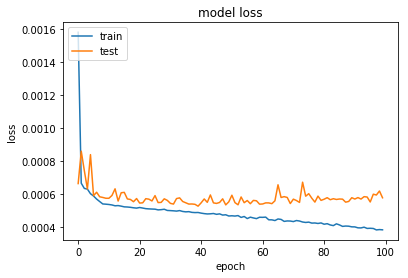

In [33]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

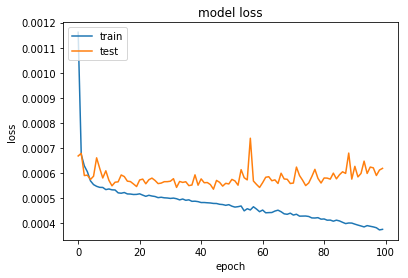

In [34]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

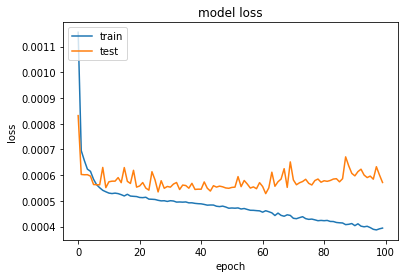

In [42]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

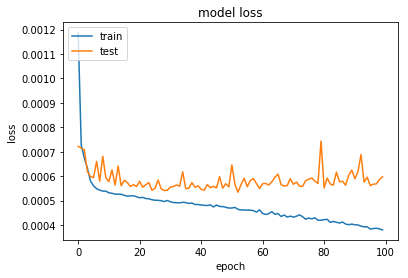

In [49]:
여기임 50 aug
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [78]:
model.load_weights("saved_weights/multi_pm2.5_onestep_50.hdf5")

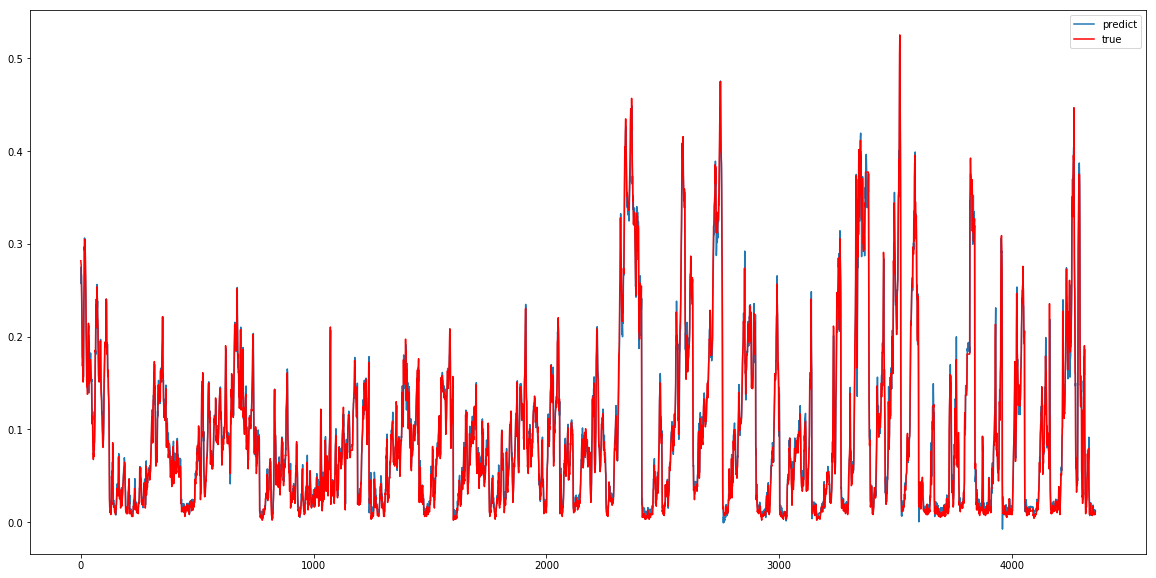

Test RMSE: 0.01778
Test MAE: 0.01078
Test MSE: 0.00032
Test RMSE: 19.31244
Test MAE: 11.70927


In [72]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_q,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

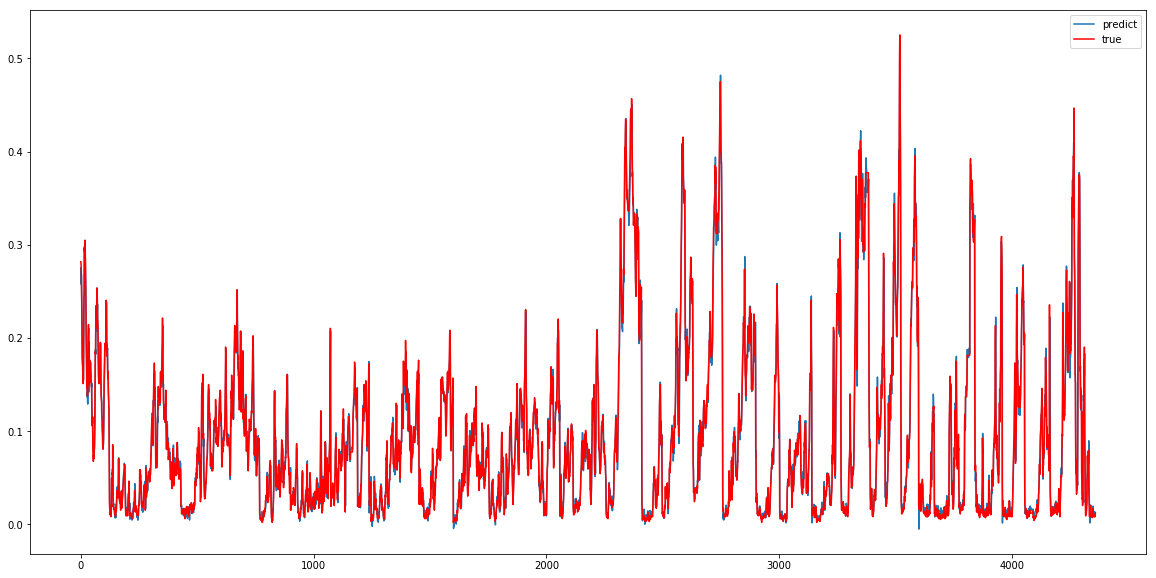

Test RMSE: 0.01782
Test MAE: 0.01053
Test MSE: 0.00032
Test RMSE: 19.35665
Test MAE: 11.43104


In [79]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_q,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

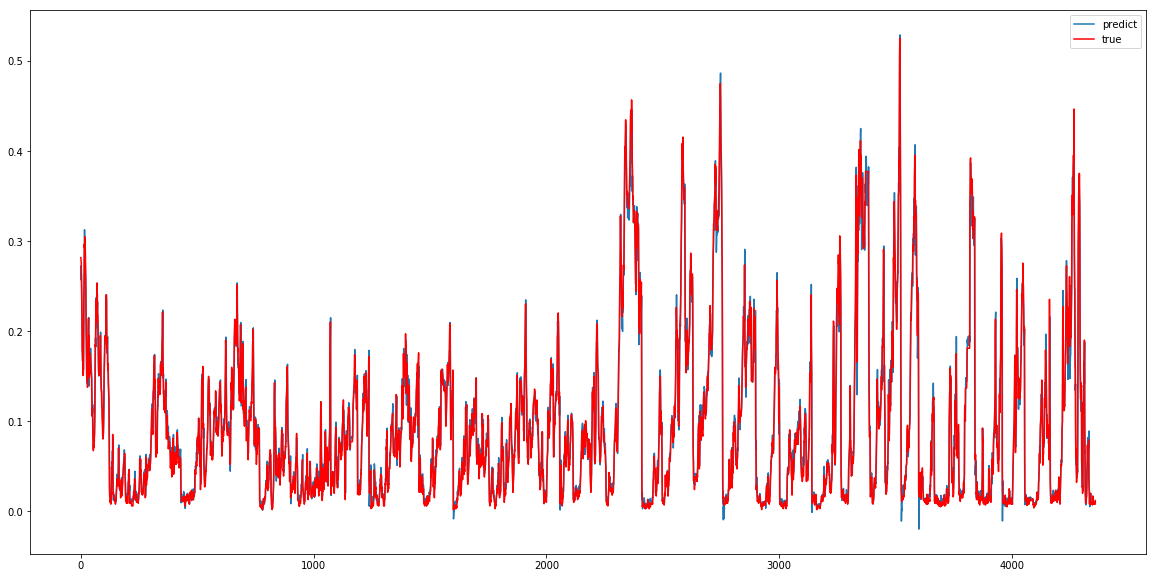

Test RMSE: 0.01770
Test MAE: 0.01058
Test MSE: 0.00031
Test RMSE: 19.21748
Test MAE: 11.49298


In [44]:
##50 non aug
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_q,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

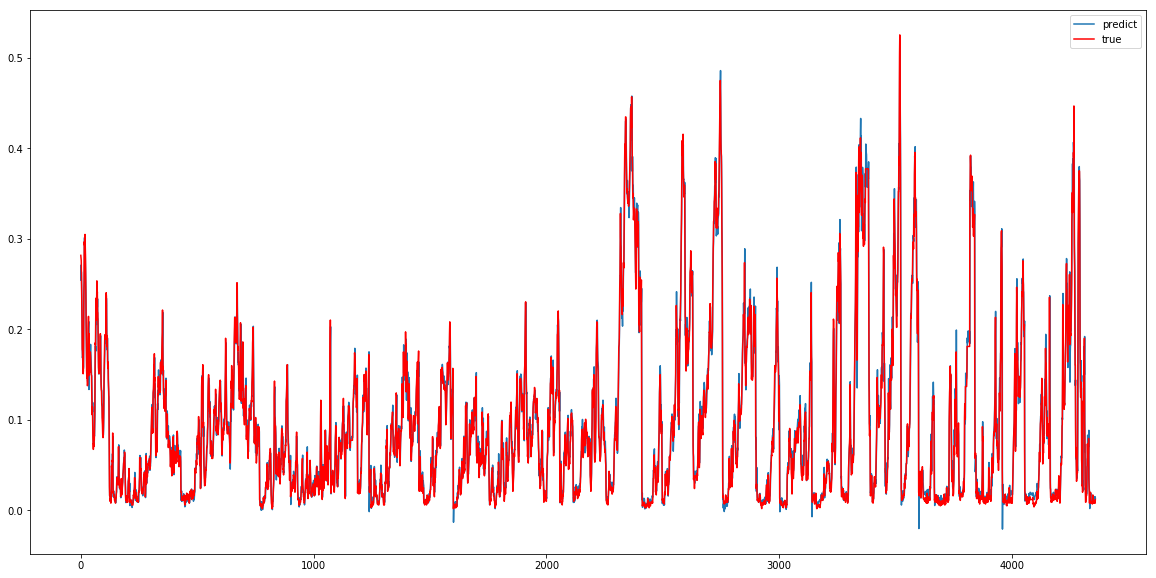

Test RMSE: 0.01781
Test MAE: 0.01057
Test MSE: 0.00032
Test RMSE: 19.34020
Test MAE: 11.47741


In [36]:
##100 non aug
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_q,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

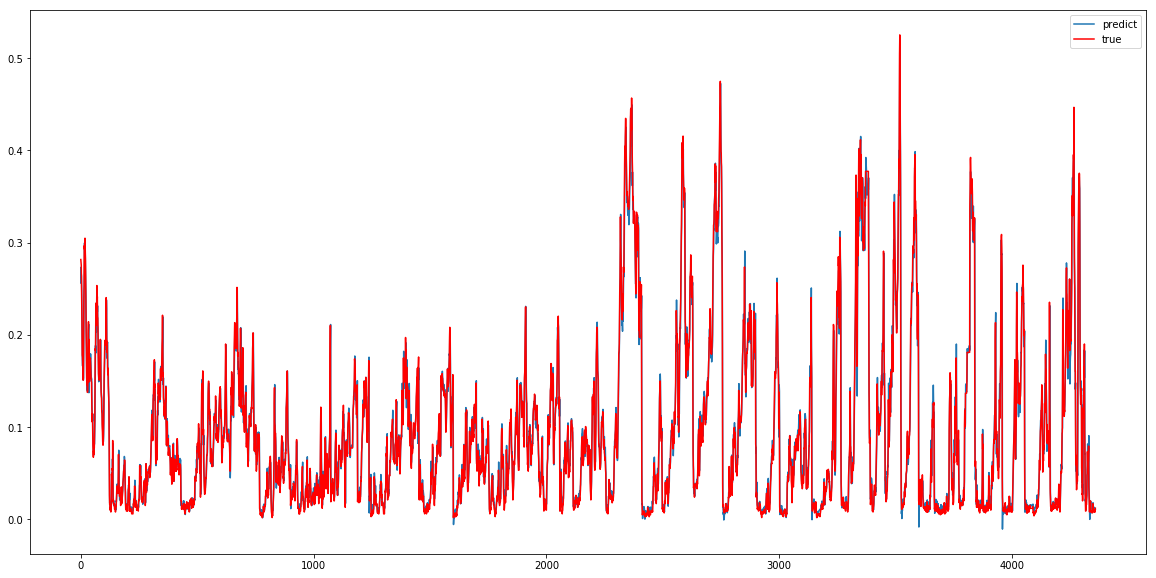

Test RMSE: 0.01752
Test MAE: 0.01039
Test MSE: 0.00031
Test RMSE: 19.02367
Test MAE: 11.27859


In [29]:
## 100 aug 30

from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_q,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

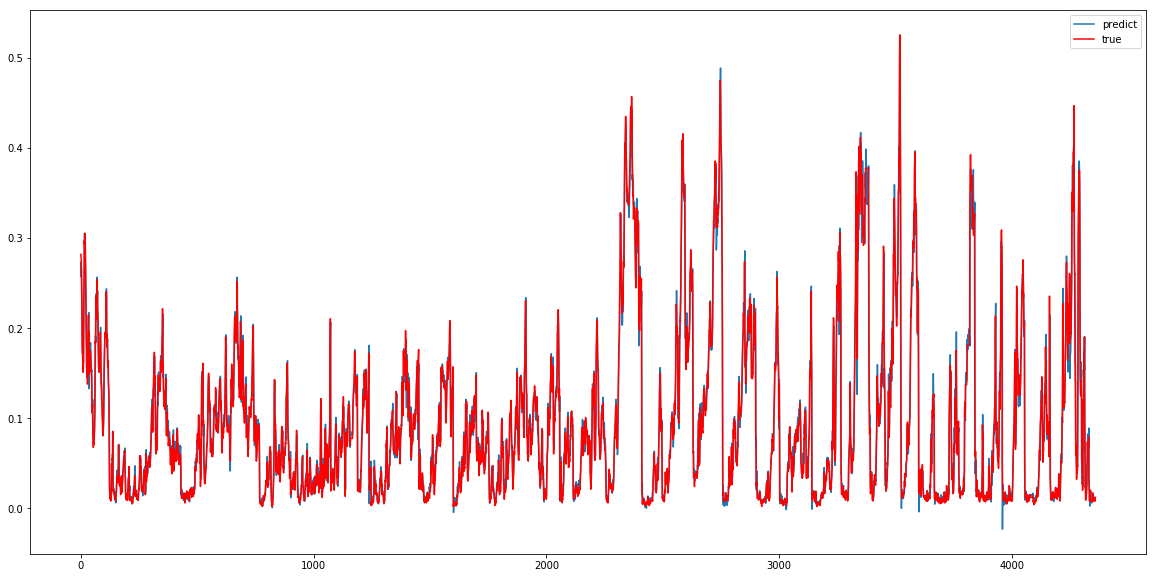

Test RMSE: 0.01762
Test MAE: 0.01046
Test MSE: 0.00031
Test RMSE: 19.13691
Test MAE: 11.35475


In [75]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_o,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

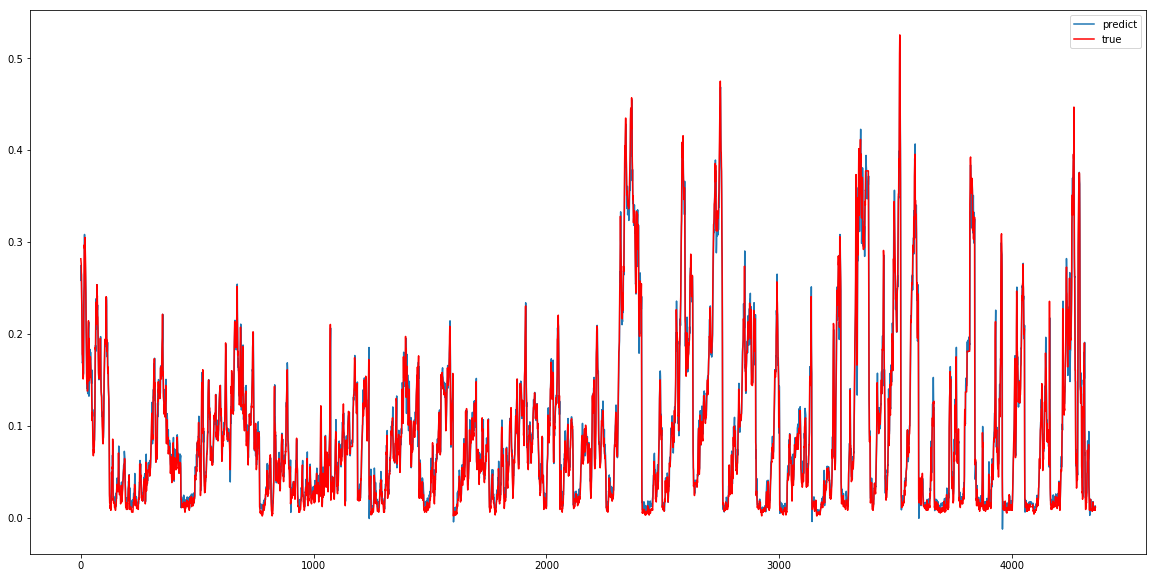

Test RMSE: 0.01788
Test MAE: 0.01089
Test MSE: 0.00032
Test RMSE: 19.41272
Test MAE: 11.82459


In [35]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_o,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

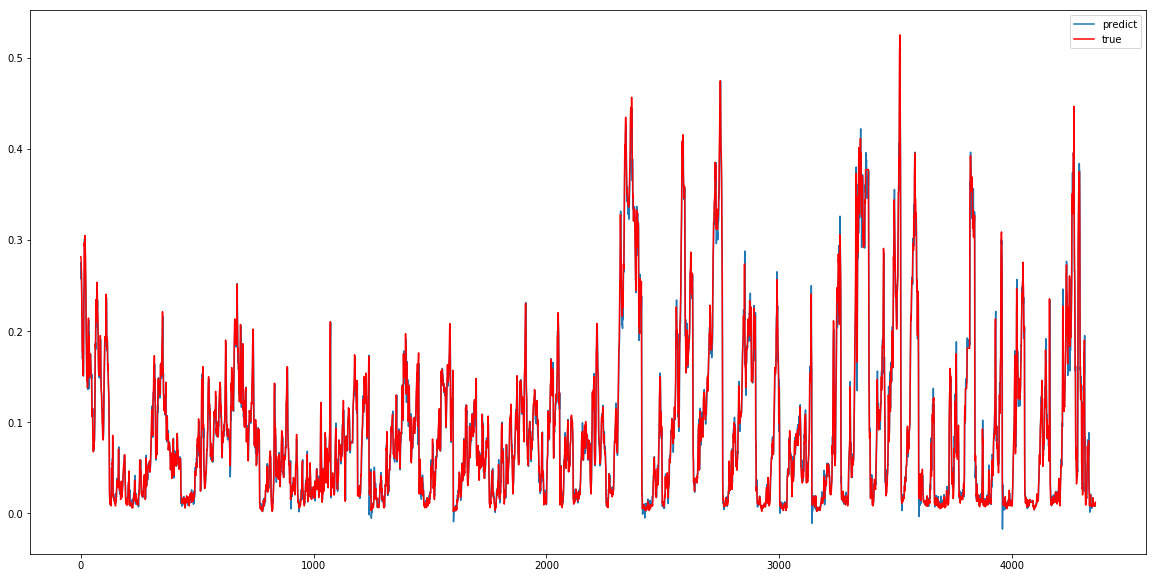

Test RMSE: 0.01766
Test MAE: 0.01039
Test MSE: 0.00031
Test RMSE: 19.18139
Test MAE: 11.28539


In [61]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_q,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

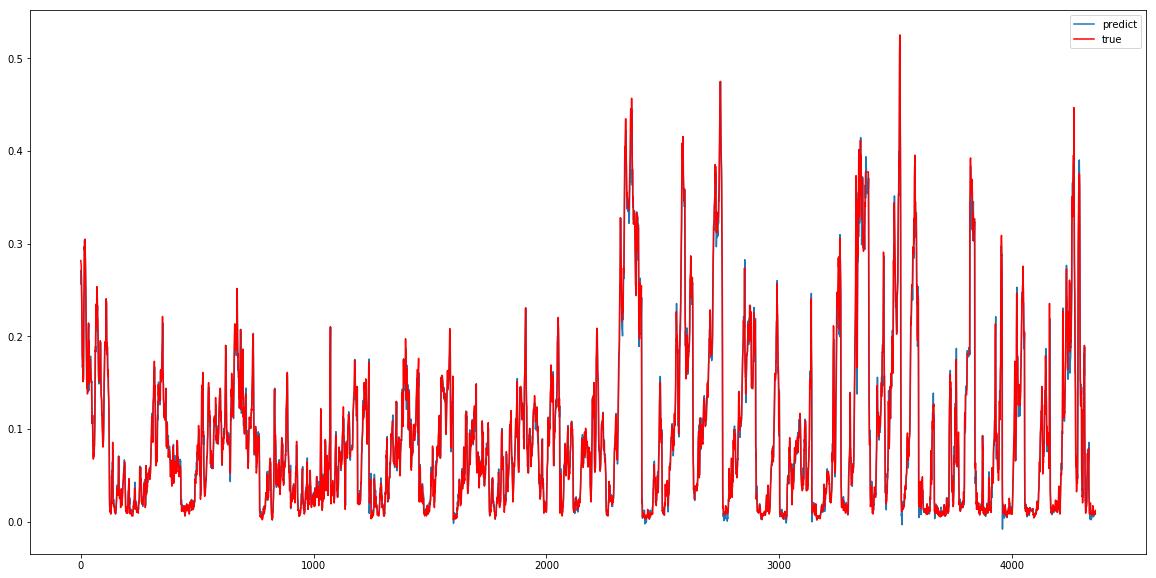

Test RMSE: 0.01749
Test MAE: 0.01027
Test MSE: 0.00031
Test RMSE: 18.99094
Test MAE: 11.15593


In [63]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_q,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

### CNN-LSTM

In [14]:
first_input = Input(shape=(24,11))

in1=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(150)(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/pm2.5_1dcnn-lstm.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

# fit model9
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 35035 samples, validate on 4358 samples
Epoch 1/200
34600/35035 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 00001: val_loss improved from inf to 0.00105, saving model to saved_weights/pm2.5_1dcnn-lstm.hdf5
35035/35035 [==============================] - 6s 164us/sample - loss: 0.0021 - val_loss: 0.0010
Epoch 2/200
34600/35035 [============================>.] - ETA: 0s - loss: 8.1078e-04
Epoch 00002: val_loss improved from 0.00105 to 0.00077, saving model to saved_weights/pm2.5_1dcnn-lstm.hdf5
35035/35035 [==============================] - 4s 121us/sample - loss: 8.1141e-04 - val_loss: 7.6727e-04
Epoch 3/200
34600/35035 [============================>.] - ETA: 0s - loss: 6.8190e-04
Epoch 00003: val_loss improved from 0.00077 to 0.00065, saving model to saved_weights/pm2.5_1dcnn-lstm.hdf5
35035/35035 [==============================] - 4s 121us/sample - loss: 6.7992e-04 - val_loss: 6.5497e-04
Epoch 4/200
34600/35035 [============================>.] - ETA: 0s - l

Epoch 33/200
34600/35035 [============================>.] - ETA: 0s - loss: 4.5357e-04
Epoch 00033: val_loss did not improve from 0.00057
35035/35035 [==============================] - 4s 120us/sample - loss: 4.5407e-04 - val_loss: 6.0015e-04
Epoch 34/200
34600/35035 [============================>.] - ETA: 0s - loss: 4.4886e-04
Epoch 00034: val_loss did not improve from 0.00057
35035/35035 [==============================] - 4s 120us/sample - loss: 4.4756e-04 - val_loss: 5.9420e-04
Epoch 35/200
34600/35035 [============================>.] - ETA: 0s - loss: 4.5775e-04
Epoch 00035: val_loss did not improve from 0.00057
35035/35035 [==============================] - 4s 120us/sample - loss: 4.5858e-04 - val_loss: 6.1023e-04
Epoch 36/200
34600/35035 [============================>.] - ETA: 0s - loss: 4.3959e-04
Epoch 00036: val_loss did not improve from 0.00057
35035/35035 [==============================] - 4s 119us/sample - loss: 4.3791e-04 - val_loss: 5.8993e-04
Epoch 37/200
34600/35035 [==

KeyboardInterrupt: 

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 11)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 24, 64)            3584      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 64)            4160      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 150)               129000    
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 136,895
Trainable params: 136,895
Non-trainable params: 0
_______________________________________________________

In [16]:
model.load_weights("saved_weights/pm2.5_1dcnn-lstm.hdf5")

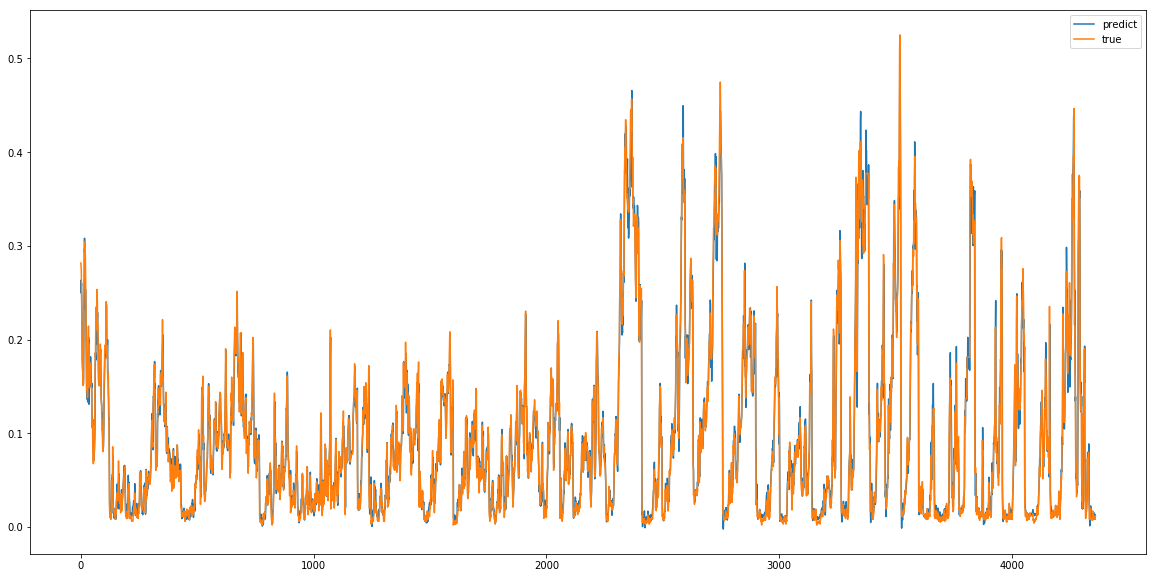

Test RMSE: 0.01847
Test MAE: 0.01133
Test MSE: 0.00034
Test RMSE: 20.05862
Test MAE: 12.29898


In [17]:
#1dcnn(5,1)-lstm

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


### LSTM-CNN

In [22]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,11))

in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=5, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=5, activation='relu')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')


In [23]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 24, 11)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 150)           97200     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 20, 64)            48064     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 20, 64)            4160      
_________________________________________________________________
extractor (MaxPooling1D)     (None, 10, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 641 

In [24]:
checkpoint_path = "saved_weights/pm2.5_lstmcnn_150_5_1_exp.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [25]:
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 35035 samples, validate on 4358 samples
Epoch 1/200
34900/35035 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 00001: val_loss improved from inf to 0.00143, saving model to saved_weights/pm2.5_lstmcnn_150_5_1_exp.hdf5
35035/35035 [==============================] - 9s 264us/sample - loss: 0.0028 - val_loss: 0.0014
Epoch 2/200
34900/35035 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00002: val_loss improved from 0.00143 to 0.00102, saving model to saved_weights/pm2.5_lstmcnn_150_5_1_exp.hdf5
35035/35035 [==============================] - 8s 220us/sample - loss: 0.0012 - val_loss: 0.0010
Epoch 3/200
34900/35035 [============================>.] - ETA: 0s - loss: 8.8011e-04
Epoch 00003: val_loss improved from 0.00102 to 0.00098, saving model to saved_weights/pm2.5_lstmcnn_150_5_1_exp.hdf5
35035/35035 [==============================] - 8s 220us/sample - loss: 8.8025e-04 - val_loss: 9.8265e-04
Epoch 4/200
34900/35035 [============================>.

Epoch 32/200
34900/35035 [============================>.] - ETA: 0s - loss: 5.1167e-04
Epoch 00032: val_loss did not improve from 0.00055
35035/35035 [==============================] - 8s 220us/sample - loss: 5.1203e-04 - val_loss: 5.6884e-04
Epoch 33/200
34900/35035 [============================>.] - ETA: 0s - loss: 5.1280e-04
Epoch 00033: val_loss did not improve from 0.00055
35035/35035 [==============================] - 8s 220us/sample - loss: 5.1210e-04 - val_loss: 6.1240e-04
Epoch 34/200
34900/35035 [============================>.] - ETA: 0s - loss: 5.0366e-04
Epoch 00034: val_loss did not improve from 0.00055
35035/35035 [==============================] - 8s 220us/sample - loss: 5.0374e-04 - val_loss: 6.4165e-04
Epoch 35/200
34900/35035 [============================>.] - ETA: 0s - loss: 4.9880e-04
Epoch 00035: val_loss did not improve from 0.00055
35035/35035 [==============================] - 8s 220us/sample - loss: 4.9862e-04 - val_loss: 6.1331e-04
Epoch 36/200
34900/35035 [==

Epoch 66/200
34900/35035 [============================>.] - ETA: 0s - loss: 4.0536e-04
Epoch 00066: val_loss did not improve from 0.00055
35035/35035 [==============================] - 8s 219us/sample - loss: 4.0513e-04 - val_loss: 6.1617e-04
Epoch 67/200
34900/35035 [============================>.] - ETA: 0s - loss: 4.1754e-04
Epoch 00067: val_loss did not improve from 0.00055
35035/35035 [==============================] - 8s 220us/sample - loss: 4.1780e-04 - val_loss: 6.0653e-04
Epoch 68/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.9937e-04
Epoch 00068: val_loss did not improve from 0.00055
35035/35035 [==============================] - 8s 220us/sample - loss: 3.9966e-04 - val_loss: 6.3651e-04
Epoch 69/200
34900/35035 [============================>.] - ETA: 0s - loss: 4.0828e-04
Epoch 00069: val_loss did not improve from 0.00055
35035/35035 [==============================] - 8s 220us/sample - loss: 4.0799e-04 - val_loss: 6.2866e-04
Epoch 70/200
34900/35035 [==

KeyboardInterrupt: 

In [26]:
model.load_weights("saved_weights/pm2.5_lstmcnn_150_5_1_exp.hdf5")

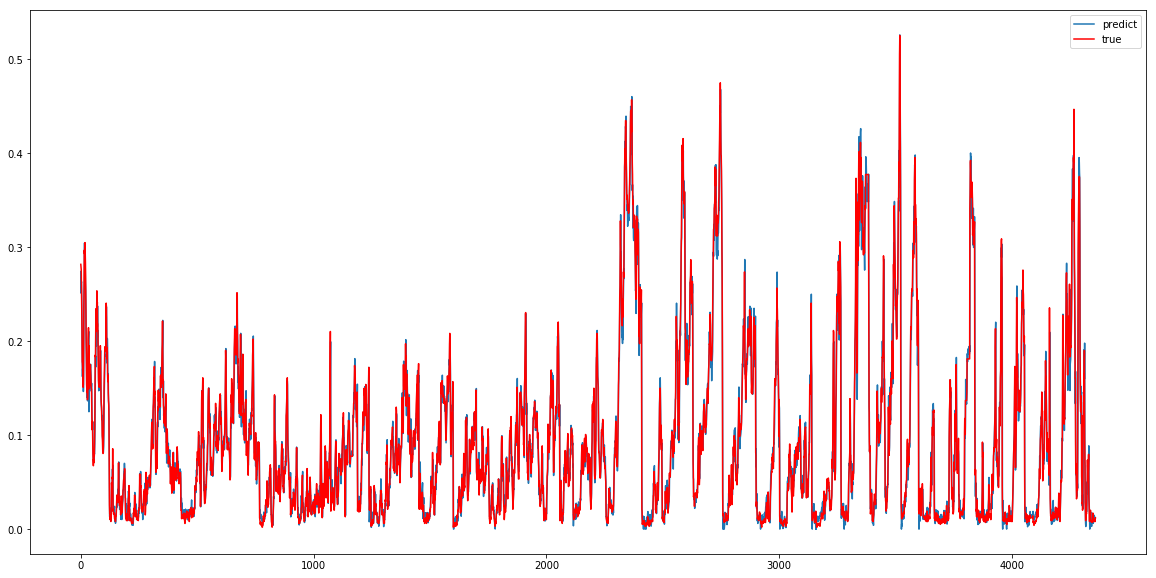

Test RMSE: 0.01789
Test MAE: 0.01100
Test MSE: 0.00032
Test RMSE: 19.43214
Test MAE: 11.94186


In [27]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

### Timedistributed 1d-CNN

In [679]:
from tensorflow.keras.models import *

first_input = Input(shape=(None,24,11))

in1=TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu'))(first_input)
#in1= BatchNormalization(scale=False)(in1)
#in0=TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in1)

#in1=add([in0,in1],name='extractor')
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/pm2.5_conv1d_timedist_5_1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

# fit model9
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 35035 samples, validate on 4358 samples
Epoch 1/200
34400/35035 [============================>.] - ETA: 0s - loss: 0.0030
Epoch 00001: val_loss improved from inf to 0.00202, saving model to saved_weights/pm2.5_conv1d_timedist_5_1.hdf5
35035/35035 [==============================] - 1s 35us/sample - loss: 0.0029 - val_loss: 0.0020
Epoch 2/200
34300/35035 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00002: val_loss improved from 0.00202 to 0.00123, saving model to saved_weights/pm2.5_conv1d_timedist_5_1.hdf5
35035/35035 [==============================] - 1s 25us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 3/200
34400/35035 [============================>.] - ETA: 0s - loss: 9.6360e-04
Epoch 00003: val_loss improved from 0.00123 to 0.00104, saving model to saved_weights/pm2.5_conv1d_timedist_5_1.hdf5
35035/35035 [==============================] - 1s 25us/sample - loss: 9.6201e-04 - val_loss: 0.0010
Epoch 4/200
34000/35035 [============================>.] - ETA

Epoch 32/200
34500/35035 [============================>.] - ETA: 0s - loss: 5.3011e-04
Epoch 00032: val_loss did not improve from 0.00069
35035/35035 [==============================] - 1s 24us/sample - loss: 5.2925e-04 - val_loss: 7.2059e-04
Epoch 33/200
34500/35035 [============================>.] - ETA: 0s - loss: 5.1520e-04
Epoch 00033: val_loss did not improve from 0.00069
35035/35035 [==============================] - 1s 24us/sample - loss: 5.1646e-04 - val_loss: 7.3549e-04
Epoch 34/200
34000/35035 [============================>.] - ETA: 0s - loss: 5.1373e-04
Epoch 00034: val_loss did not improve from 0.00069
35035/35035 [==============================] - 1s 25us/sample - loss: 5.1170e-04 - val_loss: 7.2406e-04
Epoch 35/200
33900/35035 [============================>.] - ETA: 0s - loss: 5.1254e-04
Epoch 00035: val_loss did not improve from 0.00069
35035/35035 [==============================] - 1s 25us/sample - loss: 5.1184e-04 - val_loss: 8.1158e-04
Epoch 36/200
34400/35035 [======

34500/35035 [============================>.] - ETA: 0s - loss: 4.4295e-04
Epoch 00065: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 4.4406e-04 - val_loss: 7.6006e-04
Epoch 66/200
34600/35035 [============================>.] - ETA: 0s - loss: 4.3488e-04
Epoch 00066: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 4.3481e-04 - val_loss: 7.6768e-04
Epoch 67/200
34300/35035 [============================>.] - ETA: 0s - loss: 4.3774e-04
Epoch 00067: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 4.3886e-04 - val_loss: 7.5026e-04
Epoch 68/200
33900/35035 [============================>.] - ETA: 0s - loss: 4.4765e-04
Epoch 00068: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 25us/sample - loss: 4.4836e-04 - val_loss: 6.8948e-04
Epoch 69/200
34100/35035 [===================

Epoch 99/200
34200/35035 [============================>.] - ETA: 0s - loss: 3.9989e-04
Epoch 00099: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 25us/sample - loss: 4.0052e-04 - val_loss: 7.0351e-04
Epoch 100/200
34600/35035 [============================>.] - ETA: 0s - loss: 4.0167e-04
Epoch 00100: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 26us/sample - loss: 4.0348e-04 - val_loss: 7.3525e-04
Epoch 101/200
34300/35035 [============================>.] - ETA: 0s - loss: 4.1197e-04
Epoch 00101: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 4.1116e-04 - val_loss: 7.0708e-04
Epoch 102/200
34500/35035 [============================>.] - ETA: 0s - loss: 3.9827e-04
Epoch 00102: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.9846e-04 - val_loss: 7.1734e-04
Epoch 103/200
34600/35035 [==

Epoch 133/200
34600/35035 [============================>.] - ETA: 0s - loss: 3.8315e-04
Epoch 00133: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.8324e-04 - val_loss: 7.7266e-04
Epoch 134/200
34400/35035 [============================>.] - ETA: 0s - loss: 3.7876e-04
Epoch 00134: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.7870e-04 - val_loss: 7.4638e-04
Epoch 135/200
34500/35035 [============================>.] - ETA: 0s - loss: 3.9303e-04
Epoch 00135: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.9337e-04 - val_loss: 8.0256e-04
Epoch 136/200
34500/35035 [============================>.] - ETA: 0s - loss: 3.8116e-04
Epoch 00136: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.8110e-04 - val_loss: 7.5633e-04
Epoch 137/200
34100/35035 [=

Epoch 167/200
34400/35035 [============================>.] - ETA: 0s - loss: 3.5805e-04
Epoch 00167: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.5848e-04 - val_loss: 8.0800e-04
Epoch 168/200
34300/35035 [============================>.] - ETA: 0s - loss: 3.6413e-04
Epoch 00168: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.6435e-04 - val_loss: 8.4778e-04
Epoch 169/200
34500/35035 [============================>.] - ETA: 0s - loss: 3.6824e-04
Epoch 00169: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.6742e-04 - val_loss: 8.0005e-04
Epoch 170/200
34400/35035 [============================>.] - ETA: 0s - loss: 3.8417e-04
Epoch 00170: val_loss did not improve from 0.00068
35035/35035 [==============================] - 1s 24us/sample - loss: 3.8616e-04 - val_loss: 7.8910e-04
Epoch 171/200
34500/35035 [=

In [676]:
model.load_weights("saved_weights/pm2.5_conv1d_5_1.hdf5")

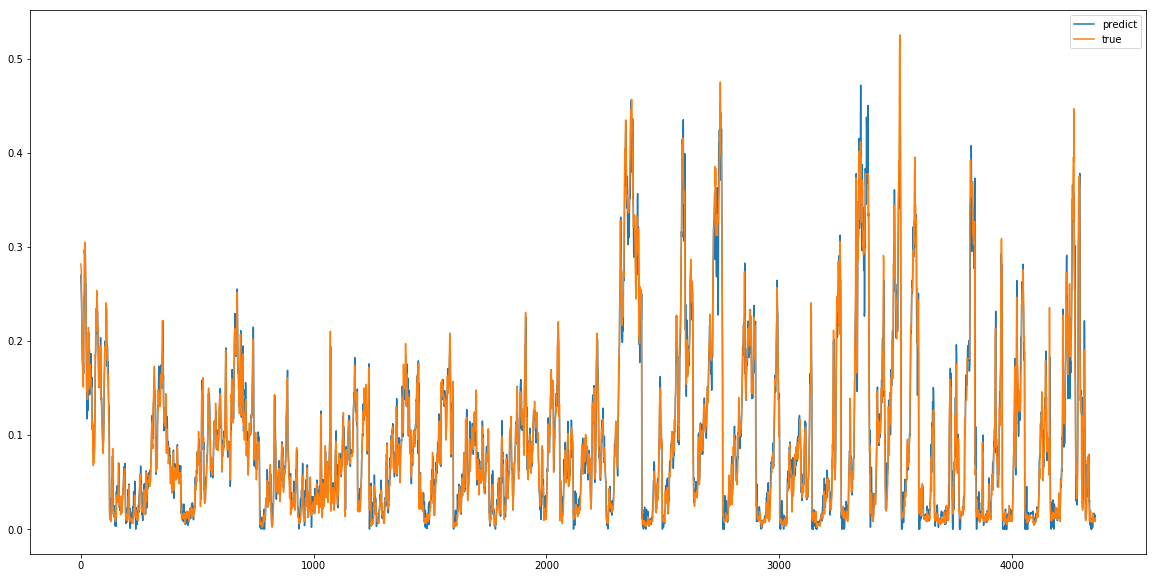

Test RMSE: 0.02106
Test MAE: 0.01326
Test MSE: 0.00044
Test RMSE: 22.86943
Test MAE: 14.40256


In [680]:
#1dcnn(5,1)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


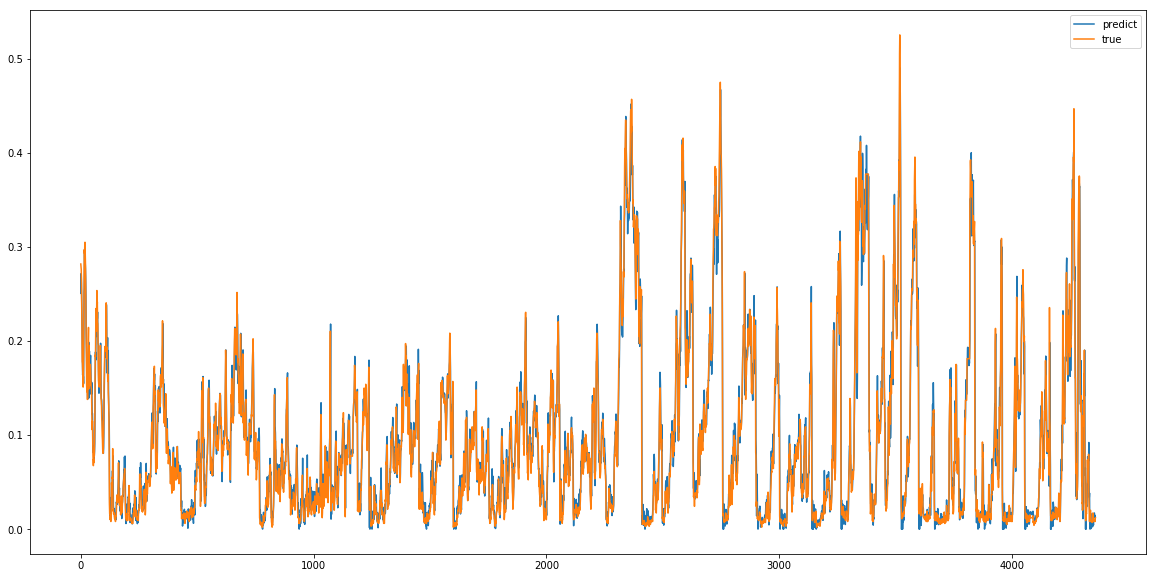

Test RMSE: 0.01964
Test MAE: 0.01262
Test MSE: 0.00039
Test RMSE: 21.33051
Test MAE: 13.71028


In [677]:
#1dcnn(5,3,1)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


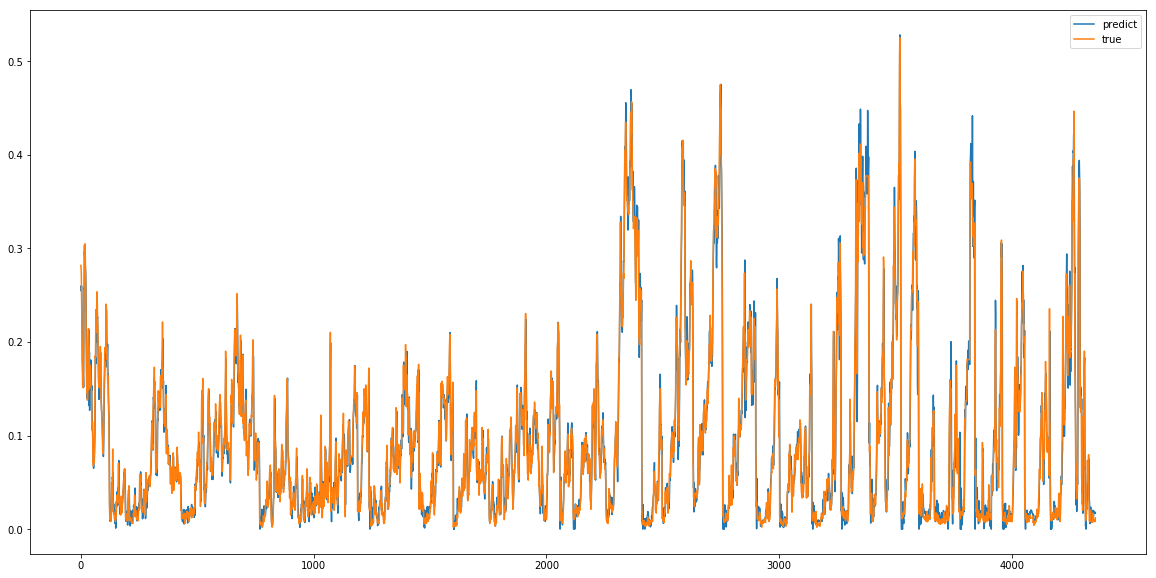

Test RMSE: 0.01985
Test MAE: 0.01248
Test MSE: 0.00039
Test RMSE: 21.55784
Test MAE: 13.55454


In [671]:
# time 1dcnn(5,3,1)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


### Bidirectional LSTM

In [663]:
first_input = Input(shape=(trainX.shape[1],trainX.shape[2]))

in1=Bidirectional(LSTM(150))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "saved_weights/pm2.5_timebilstm.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "model_28135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       [(None, 24, 11)]          0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 300)               194400    
_________________________________________________________________
dense_116 (Dense)            (None, 1)                 301       
Total params: 194,701
Trainable params: 194,701
Non-trainable params: 0
_________________________________________________________________
Train on 35035 samples, validate on 4358 samples
Epoch 1/200
35008/35035 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00001: val_loss improved from inf to 0.00064, saving model to saved_weights/pm2.5_timebilstm.hdf5
35035/35035 [==============================] - 16s 468us/sample - loss: 0.0014 - val_loss: 6.3933e-04
Epoch 2/200
34912/35035 [=================

Epoch 30/200
34912/35035 [============================>.] - ETA: 0s - loss: 5.0566e-04
Epoch 00030: val_loss improved from 0.00054 to 0.00054, saving model to saved_weights/pm2.5_timebilstm.hdf5
35035/35035 [==============================] - 14s 411us/sample - loss: 5.0523e-04 - val_loss: 5.3943e-04
Epoch 31/200
34912/35035 [============================>.] - ETA: 0s - loss: 4.9787e-04
Epoch 00031: val_loss did not improve from 0.00054
35035/35035 [==============================] - 14s 411us/sample - loss: 4.9707e-04 - val_loss: 5.5338e-04
Epoch 32/200
35008/35035 [============================>.] - ETA: 0s - loss: 4.9815e-04
Epoch 00032: val_loss did not improve from 0.00054
35035/35035 [==============================] - 14s 410us/sample - loss: 4.9816e-04 - val_loss: 5.6207e-04
Epoch 33/200
34912/35035 [============================>.] - ETA: 0s - loss: 4.9411e-04
Epoch 00033: val_loss did not improve from 0.00054
35035/35035 [==============================] - 14s 410us/sample - loss: 4

Epoch 63/200
34944/35035 [============================>.] - ETA: 0s - loss: 4.4455e-04
Epoch 00063: val_loss did not improve from 0.00053
35035/35035 [==============================] - 19s 554us/sample - loss: 4.4543e-04 - val_loss: 5.4628e-04
Epoch 64/200
34976/35035 [============================>.] - ETA: 0s - loss: 4.5665e-04
Epoch 00064: val_loss improved from 0.00053 to 0.00053, saving model to saved_weights/pm2.5_timebilstm.hdf5
35035/35035 [==============================] - 22s 642us/sample - loss: 4.5624e-04 - val_loss: 5.2807e-04
Epoch 65/200
34976/35035 [============================>.] - ETA: 0s - loss: 4.5360e-04
Epoch 00065: val_loss did not improve from 0.00053
35035/35035 [==============================] - 19s 550us/sample - loss: 4.5360e-04 - val_loss: 5.4334e-04
Epoch 66/200
34944/35035 [============================>.] - ETA: 0s - loss: 4.4589e-04
Epoch 00066: val_loss did not improve from 0.00053
35035/35035 [==============================] - 19s 537us/sample - loss: 4

KeyboardInterrupt: 

In [664]:
model.load_weights("saved_weights/pm2.5_timebilstm.hdf5")

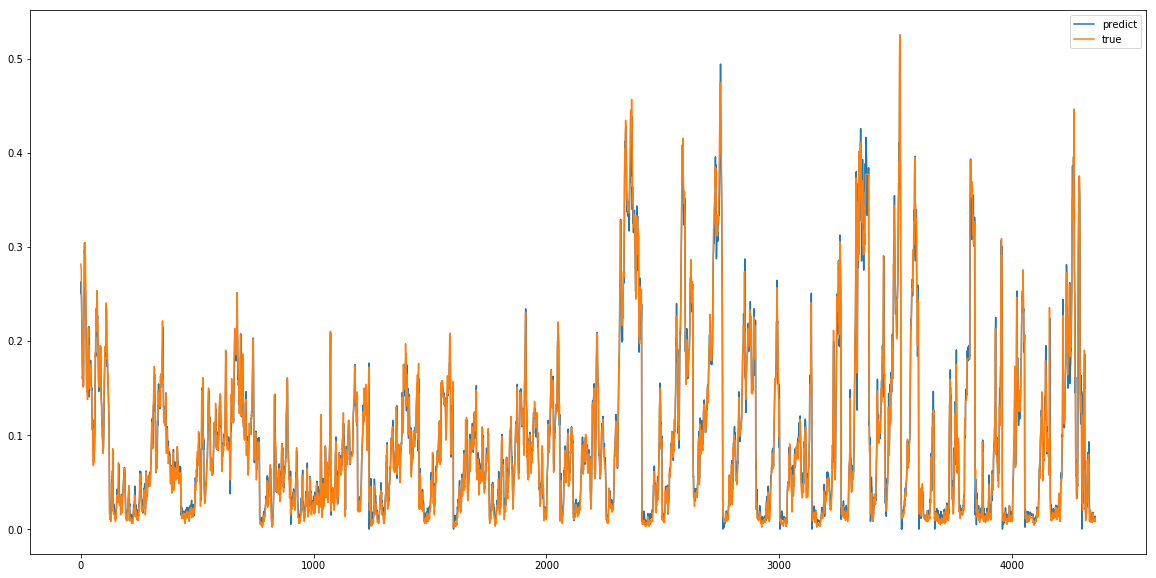

Test RMSE: 0.01792
Test MAE: 0.01094
Test MSE: 0.00032
Test RMSE: 19.46334
Test MAE: 11.88045


In [665]:
##bilstm(150)
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)

### 1d-CNN

In [446]:
first_input = Input(shape=(24,8))

in1=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/pm2.5.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model


Model: "model_28107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_80 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_214 (Conv1D)          (None, 24, 64)            2624      
_________________________________________________________________
conv1d_216 (Conv1D)          (None, 24, 64)            4160      
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 12, 64)            0         
_________________________________________________________________
flatten_73 (Flatten)         (None, 768)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 769       
Total params: 7,553
Trainable params: 7,553
Non-trainable params: 0
_____________________________________________________

In [382]:
model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Train on 35035 samples, validate on 4358 samples
Epoch 1/200
34592/35035 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00001: val_loss improved from inf to 0.00069, saving model to saved_weights/pm2.5.hdf5
35035/35035 [==============================] - 3s 97us/sample - loss: 0.0014 - val_loss: 6.8992e-04
Epoch 2/200
34944/35035 [============================>.] - ETA: 0s - loss: 6.8577e-04
Epoch 00002: val_loss improved from 0.00069 to 0.00065, saving model to saved_weights/pm2.5.hdf5
35035/35035 [==============================] - 3s 97us/sample - loss: 6.8521e-04 - val_loss: 6.4689e-04
Epoch 3/200
34688/35035 [============================>.] - ETA: 0s - loss: 6.2399e-04
Epoch 00003: val_loss did not improve from 0.00065
35035/35035 [==============================] - 3s 77us/sample - loss: 6.2212e-04 - val_loss: 6.8445e-04
Epoch 4/200
34528/35035 [============================>.] - ETA: 0s - loss: 5.9540e-04
Epoch 00004: val_loss improved from 0.00065 to 0.00060, saving

34720/35035 [============================>.] - ETA: 0s - loss: 5.1415e-04
Epoch 00033: val_loss did not improve from 0.00054
35035/35035 [==============================] - 3s 76us/sample - loss: 5.1461e-04 - val_loss: 5.5305e-04
Epoch 34/200
34912/35035 [============================>.] - ETA: 0s - loss: 5.0276e-04
Epoch 00034: val_loss did not improve from 0.00054
35035/35035 [==============================] - 3s 73us/sample - loss: 5.0214e-04 - val_loss: 5.4520e-04
Epoch 35/200
34784/35035 [============================>.] - ETA: 0s - loss: 5.0503e-04
Epoch 00035: val_loss did not improve from 0.00054
35035/35035 [==============================] - 3s 85us/sample - loss: 5.0570e-04 - val_loss: 5.4562e-04
Epoch 36/200
35008/35035 [============================>.] - ETA: 0s - loss: 5.1125e-04
Epoch 00036: val_loss improved from 0.00054 to 0.00054, saving model to saved_weights/pm2.5.hdf5
35035/35035 [==============================] - 3s 83us/sample - loss: 5.1115e-04 - val_loss: 5.4257e-04

Epoch 66/200
34880/35035 [============================>.] - ETA: 0s - loss: 4.8814e-04
Epoch 00066: val_loss did not improve from 0.00053
35035/35035 [==============================] - 3s 76us/sample - loss: 4.8743e-04 - val_loss: 5.4918e-04
Epoch 67/200
34752/35035 [============================>.] - ETA: 0s - loss: 4.8649e-04
Epoch 00067: val_loss did not improve from 0.00053
35035/35035 [==============================] - 3s 83us/sample - loss: 4.8689e-04 - val_loss: 5.5510e-04
Epoch 68/200
34752/35035 [============================>.] - ETA: 0s - loss: 4.8725e-04
Epoch 00068: val_loss did not improve from 0.00053
35035/35035 [==============================] - 2s 67us/sample - loss: 4.8574e-04 - val_loss: 5.3360e-04
Epoch 69/200
34496/35035 [============================>.] - ETA: 0s - loss: 4.8727e-04
Epoch 00069: val_loss did not improve from 0.00053
35035/35035 [==============================] - 3s 84us/sample - loss: 4.8503e-04 - val_loss: 5.4039e-04
Epoch 70/200
34912/35035 [======

Epoch 100/200
34208/35035 [============================>.] - ETA: 0s - loss: 4.8366e-04
Epoch 00100: val_loss did not improve from 0.00053
35035/35035 [==============================] - 2s 67us/sample - loss: 4.8096e-04 - val_loss: 5.4280e-04
Epoch 101/200
34432/35035 [============================>.] - ETA: 0s - loss: 4.7308e-04
Epoch 00101: val_loss did not improve from 0.00053
35035/35035 [==============================] - 2s 67us/sample - loss: 4.7382e-04 - val_loss: 5.8780e-04
Epoch 102/200
34432/35035 [============================>.] - ETA: 0s - loss: 4.6668e-04
Epoch 00102: val_loss did not improve from 0.00053
35035/35035 [==============================] - 2s 67us/sample - loss: 4.6940e-04 - val_loss: 6.2278e-04
Epoch 103/200
34368/35035 [============================>.] - ETA: 0s - loss: 4.7114e-04
Epoch 00103: val_loss did not improve from 0.00053
35035/35035 [==============================] - 3s 75us/sample - loss: 4.7084e-04 - val_loss: 5.6942e-04
Epoch 104/200
34432/35035 [=

Epoch 134/200
34752/35035 [============================>.] - ETA: 0s - loss: 4.5919e-04
Epoch 00134: val_loss did not improve from 0.00052
35035/35035 [==============================] - 2s 64us/sample - loss: 4.5787e-04 - val_loss: 5.5080e-04
Epoch 135/200
34880/35035 [============================>.] - ETA: 0s - loss: 4.6073e-04
Epoch 00135: val_loss did not improve from 0.00052
35035/35035 [==============================] - 3s 78us/sample - loss: 4.6268e-04 - val_loss: 5.6552e-04
Epoch 136/200
34976/35035 [============================>.] - ETA: 0s - loss: 4.6257e-04
Epoch 00136: val_loss did not improve from 0.00052
35035/35035 [==============================] - 3s 89us/sample - loss: 4.6231e-04 - val_loss: 5.5510e-04
Epoch 137/200
34688/35035 [============================>.] - ETA: 0s - loss: 4.5471e-04
Epoch 00137: val_loss did not improve from 0.00052
35035/35035 [==============================] - 3s 87us/sample - loss: 4.5461e-04 - val_loss: 5.9885e-04
Epoch 138/200
34912/35035 [=

Epoch 168/200
34944/35035 [============================>.] - ETA: 0s - loss: 4.5057e-04
Epoch 00168: val_loss did not improve from 0.00052
35035/35035 [==============================] - 2s 69us/sample - loss: 4.5072e-04 - val_loss: 5.6552e-04
Epoch 169/200
34368/35035 [============================>.] - ETA: 0s - loss: 4.5141e-04
Epoch 00169: val_loss did not improve from 0.00052
35035/35035 [==============================] - 2s 70us/sample - loss: 4.5320e-04 - val_loss: 5.8176e-04
Epoch 170/200
34784/35035 [============================>.] - ETA: 0s - loss: 4.4748e-04
Epoch 00170: val_loss did not improve from 0.00052
35035/35035 [==============================] - 2s 71us/sample - loss: 4.4648e-04 - val_loss: 5.8705e-04
Epoch 171/200
34624/35035 [============================>.] - ETA: 0s - loss: 4.4726e-04
Epoch 00171: val_loss did not improve from 0.00052
35035/35035 [==============================] - 2s 69us/sample - loss: 4.4836e-04 - val_loss: 5.8594e-04
Epoch 172/200
35008/35035 [=

In [383]:
model.load_weights("saved_weights/pm2.5.hdf5")

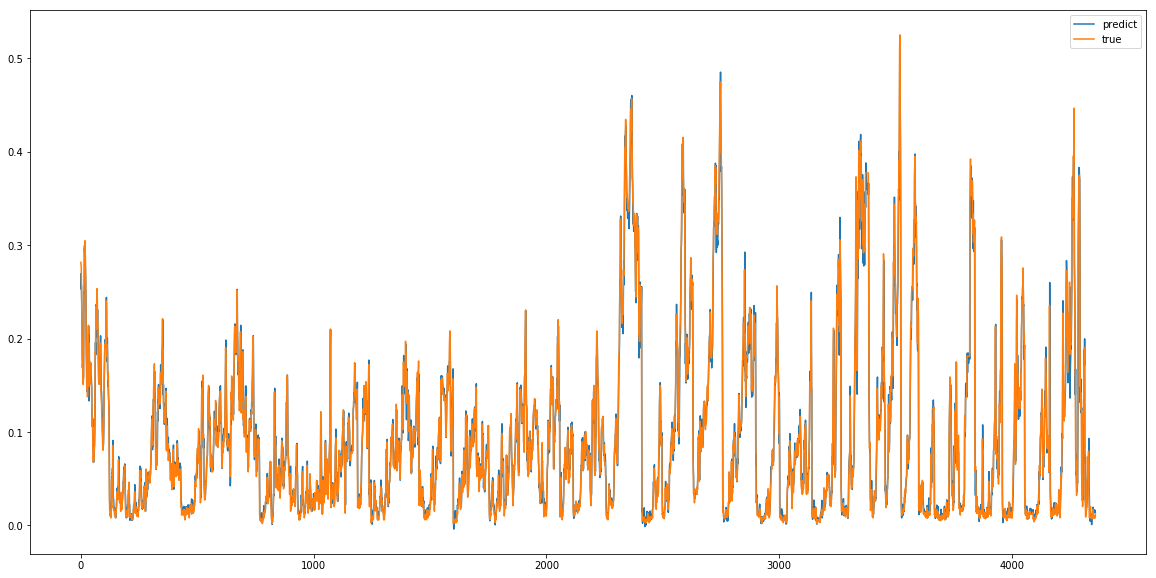

In [384]:
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [385]:
##1dcnn

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.01773


### Timedistributed LSTM-CNN

In [745]:
first_input = Input(shape=(None,24,11))

in1=TimeDistributed(LSTM(units =150 , return_sequences=True))(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in1)

#in1=add([in0,in1],name='extractor')
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')




In [746]:
model.summary()

Model: "model_28151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_125 (InputLayer)       [(None, None, 24, 11)]    0         
_________________________________________________________________
time_distributed_384 (TimeDi (None, None, 24, 150)     97200     
_________________________________________________________________
time_distributed_385 (TimeDi (None, None, 22, 64)      28864     
_________________________________________________________________
time_distributed_386 (TimeDi (None, None, 22, 64)      4160      
_________________________________________________________________
time_distributed_387 (TimeDi (None, None, 11, 64)      0         
_________________________________________________________________
time_distributed_388 (TimeDi (None, None, 704)         0         
_________________________________________________________________
dense_132 (Dense)            (None, None, 1)           

In [747]:
checkpoint_path = "saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [748]:
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 35035 samples, validate on 4358 samples
Epoch 1/200
34900/35035 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 00001: val_loss improved from inf to 0.00129, saving model to saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5
35035/35035 [==============================] - 12s 334us/sample - loss: 0.0025 - val_loss: 0.0013
Epoch 2/200
34900/35035 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00002: val_loss improved from 0.00129 to 0.00098, saving model to saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5
35035/35035 [==============================] - 8s 222us/sample - loss: 0.0011 - val_loss: 9.8348e-04
Epoch 3/200
34900/35035 [============================>.] - ETA: 0s - loss: 7.8606e-04
Epoch 00003: val_loss improved from 0.00098 to 0.00070, saving model to saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5
35035/35035 [==============================] - 8s 222us/sample - loss: 7.8500e-04 - val_loss: 7.0265e-04
Epoch 4/200
34900

Epoch 33/200
34900/35035 [============================>.] - ETA: 0s - loss: 5.0438e-04
Epoch 00033: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 5.0358e-04 - val_loss: 5.9479e-04
Epoch 34/200
34900/35035 [============================>.] - ETA: 0s - loss: 5.0077e-04
Epoch 00034: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 5.0037e-04 - val_loss: 5.9754e-04
Epoch 35/200
34900/35035 [============================>.] - ETA: 0s - loss: 4.9350e-04
Epoch 00035: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 4.9318e-04 - val_loss: 6.2706e-04
Epoch 36/200
34900/35035 [============================>.] - ETA: 0s - loss: 4.8462e-04
Epoch 00036: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 4.8414e-04 - val_loss: 6.0748e-04
Epoch 37/200
34900/35035 [==

Epoch 67/200
34900/35035 [============================>.] - ETA: 0s - loss: 4.0061e-04
Epoch 00067: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 4.0032e-04 - val_loss: 6.7587e-04
Epoch 68/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.9725e-04
Epoch 00068: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 3.9677e-04 - val_loss: 6.3896e-04
Epoch 69/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.9500e-04
Epoch 00069: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 3.9482e-04 - val_loss: 6.3722e-04
Epoch 70/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.8710e-04
Epoch 00070: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 3.8710e-04 - val_loss: 6.3130e-04
Epoch 71/200
34900/35035 [==

Epoch 101/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.0023e-04
Epoch 00101: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 3.0032e-04 - val_loss: 6.8575e-04
Epoch 102/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.0234e-04
Epoch 00102: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 3.0215e-04 - val_loss: 6.8568e-04
Epoch 103/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.9850e-04
Epoch 00103: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 2.9849e-04 - val_loss: 6.9050e-04
Epoch 104/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.9583e-04
Epoch 00104: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 2.9591e-04 - val_loss: 7.4253e-04
Epoch 105/200
34900/3503

Epoch 135/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.3214e-04
Epoch 00135: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 2.3212e-04 - val_loss: 7.7176e-04
Epoch 136/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.2495e-04
Epoch 00136: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 2.2509e-04 - val_loss: 7.7548e-04
Epoch 137/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.2928e-04
Epoch 00137: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 2.2957e-04 - val_loss: 7.7703e-04
Epoch 138/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.2232e-04
Epoch 00138: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 2.2320e-04 - val_loss: 7.7343e-04
Epoch 139/200
34900/3503

Epoch 169/200
34900/35035 [============================>.] - ETA: 0s - loss: 1.7681e-04
Epoch 00169: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 1.7693e-04 - val_loss: 7.8670e-04
Epoch 170/200
34900/35035 [============================>.] - ETA: 0s - loss: 1.6890e-04
Epoch 00170: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 1.6904e-04 - val_loss: 8.4811e-04
Epoch 171/200
34900/35035 [============================>.] - ETA: 0s - loss: 1.6668e-04
Epoch 00171: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 1.6652e-04 - val_loss: 8.0984e-04
Epoch 172/200
34900/35035 [============================>.] - ETA: 0s - loss: 1.7098e-04
Epoch 00172: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 1.7098e-04 - val_loss: 8.2017e-04
Epoch 173/200
34900/3503

In [742]:
model.load_weights("saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5")

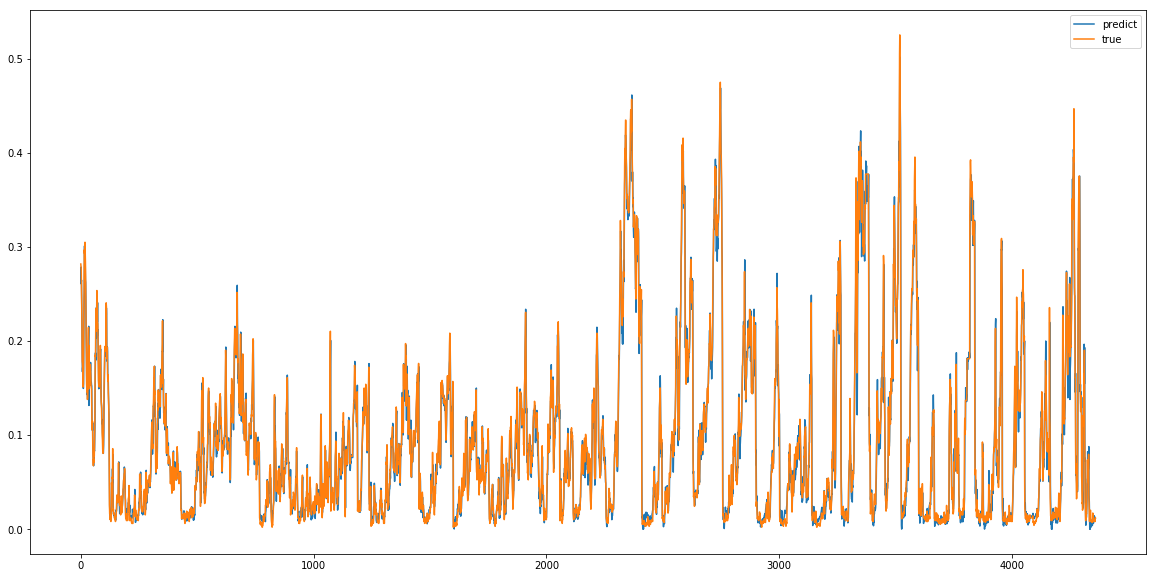

Test RMSE: 0.01806
Test MAE: 0.01101
Test MSE: 0.00033
Test RMSE: 19.61045
Test MAE: 11.95379


In [744]:
## lstm(150)-cnn(5,1),timedistribute_pm2.5_lstmcnn_150_5_11.hdf5

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae )

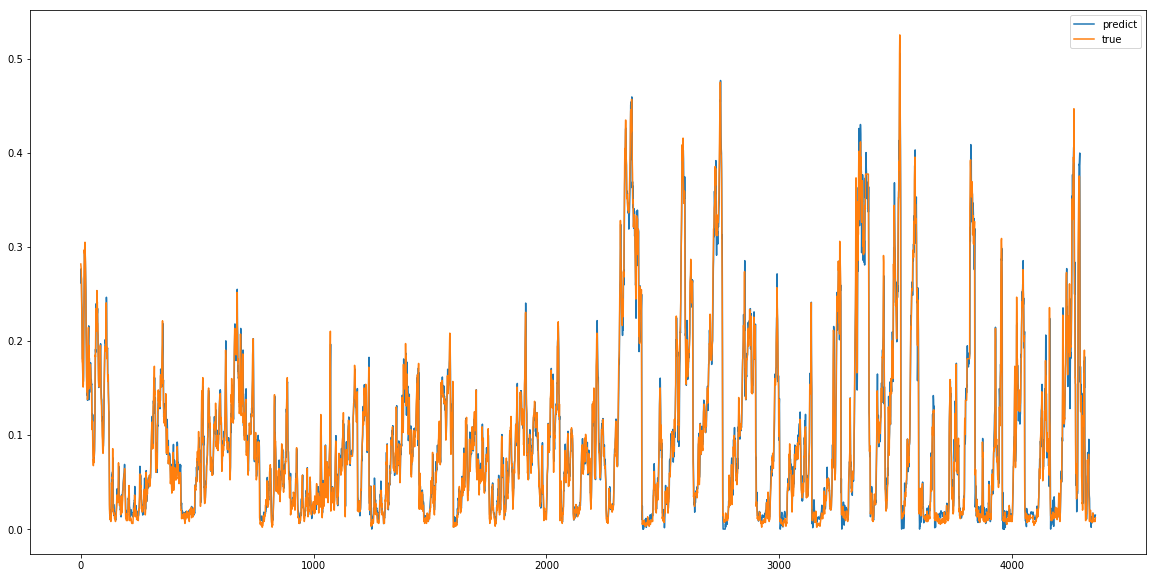

Test RMSE: 0.01818
Test MAE: 0.01115
Test MSE: 0.00033
Test RMSE: 19.740


In [638]:
## lstm(150)-cnn(3,1),timedistribute_pm2.5_lstmcnn_150_5_11.hdf5

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.3f' % rmse)

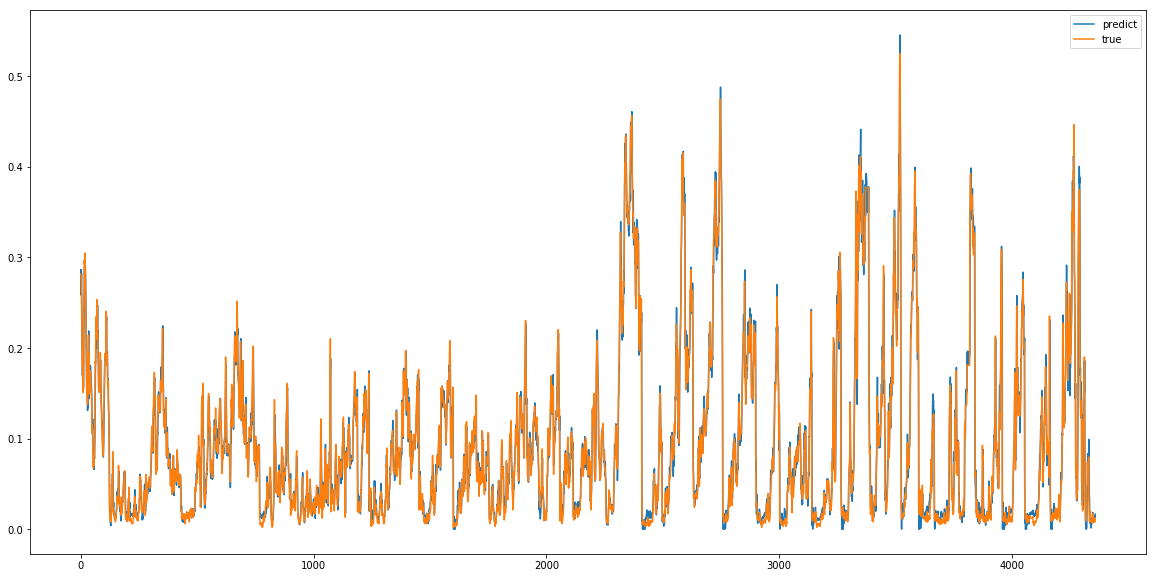

Test RMSE: 0.01849
Test MAE: 0.01152
Test MSE: 0.00034
Test RMSE: 20.077


In [589]:
## lstm(150)-cnn(5,1),timedistribute_pm2.5_lstmcnn_150_5_11.hdf5

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.3f' % rmse)

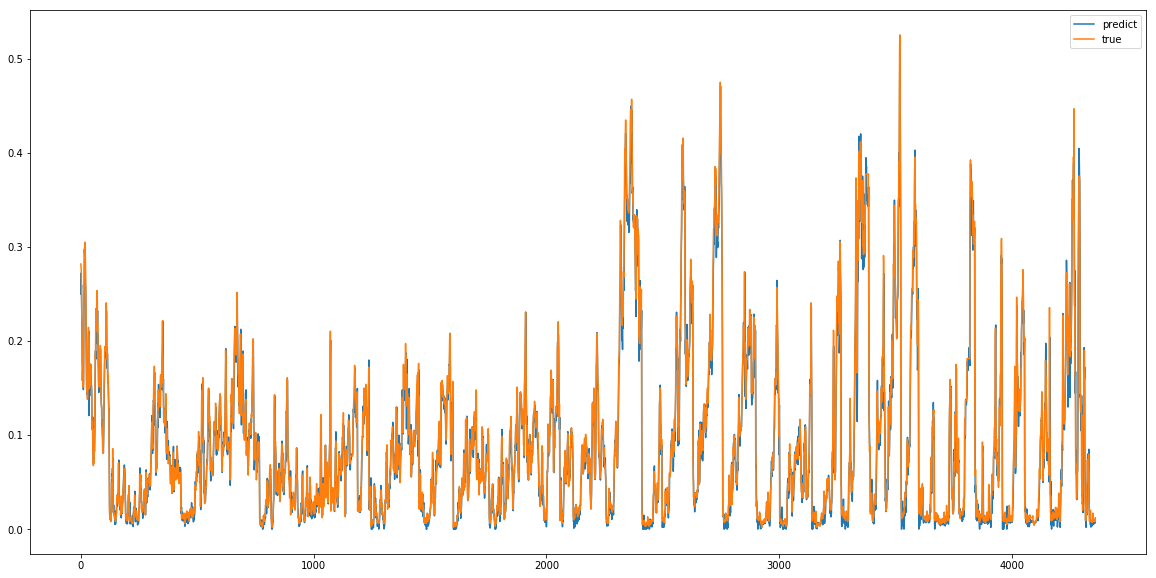

Test RMSE: 0.01820
Test MAE: 0.01122
Test MSE: 0.00033
Test RMSE: 19.764


In [577]:
## lstm(150)-cnn(5,1)

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.3f' % rmse)

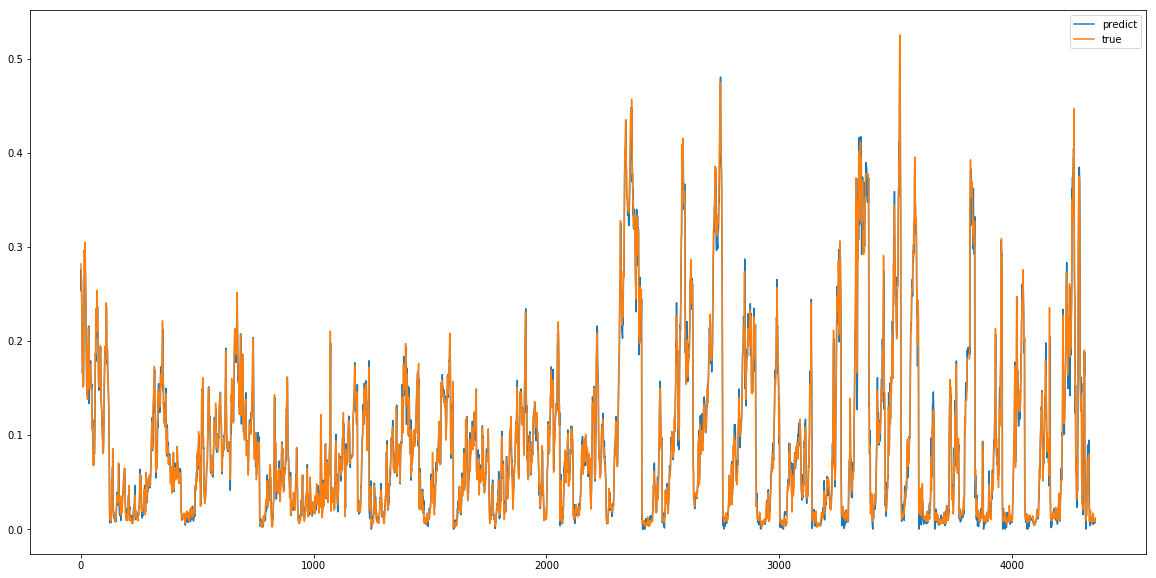

Test RMSE: 0.01770
Test MAE: 0.01071
Test MSE: 0.00031
Test RMSE: 19.21818
Test MAE: 11.63510


In [572]:
## lstm(150)-cnn(3,1)

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


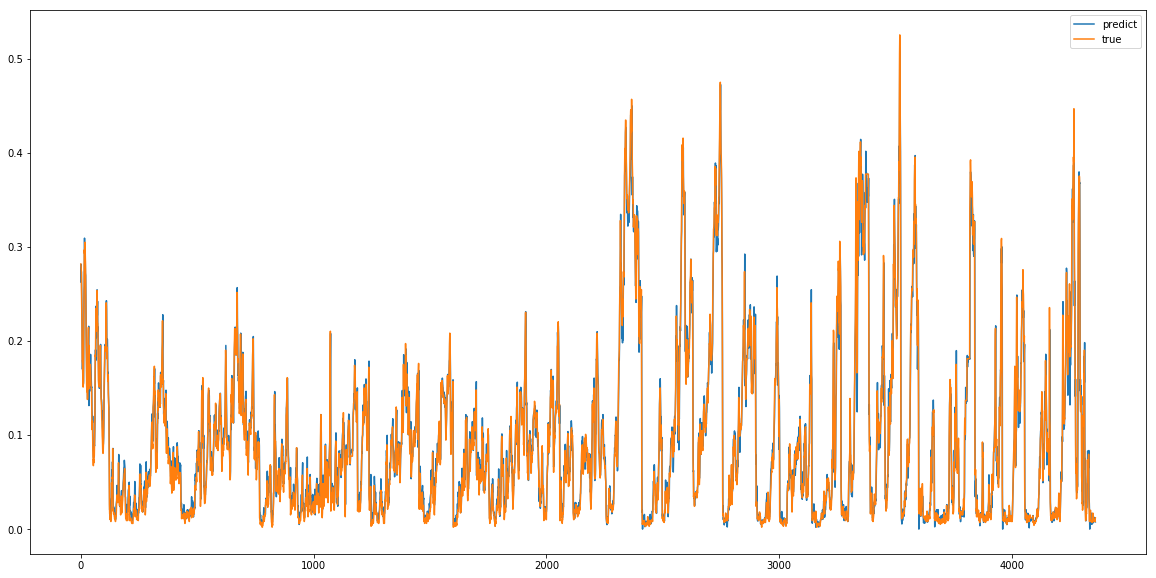

Test RMSE: 0.01783
Test MAE: 0.01091
Test MSE: 0.00032
Test RMSE: 19.36649
Test MAE: 11.85078


In [644]:
## lstm(100)-cnn(3,1)

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)

In [535]:
yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)

In [536]:
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)

In [537]:
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 19.218


### visualization

In [ ]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

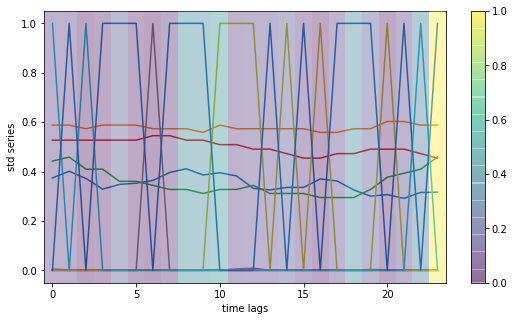

In [107]:
from scipy.ndimage import zoom
import random
id_=random.randint(0,len(testX))


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)

plt.figure(figsize=(9,5))
plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('std series'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*30), alpha=0.35)
plt.axis('off'); plt.colorbar()
np.set_printoptions(False)

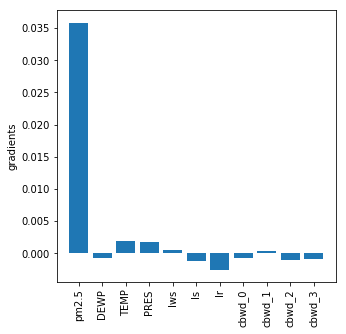

In [106]:
columns=data.columns[5:]

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(5,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)